Importing libraries and reading our preprocessed .csv files

In [46]:
import pandas as pd
import lightgbm as lgb
import matplotlib
from sklearn.model_selection import train_test_split

df_search = pd.read_csv("~/Downloads/search_session_cleaned.csv")
df_user = pd.read_csv("~/Downloads/user_session_cleaned.csv")

Preprocessing so that both the dataframes have similar patterns

In [47]:
df_search.nunique()

Unnamed: 0            10000
Unnamed: 0.1          10000
tracing_id            10000
user_id_hash           9890
timestamp_session      9998
user_session_id        9986
Dates                     1
Time                     24
order                    41
zpid                 417060
submit                    2
fav                       2
click                     2
dtype: int64

In [48]:
df_user.nunique()

Unnamed: 0       492261
Unnamed: 0.1     492261
tracing_id       492261
zpid_hash       1004015
feature1           8401
feature2           8106
feature3           8057
feature4           8160
feature5           5842
feature6           5939
feature7           8063
feature8           8051
dtype: int64

Splitting the data into train and test. Here we are trying to ensure that our data is sorted according to the timestamp so that there is no leakage of data

In [49]:
train_ratio = 0.7
df_search = df_search.sort_values(["timestamp_session"]) 
sample = df_search["tracing_id"].unique()
split_point = int(len(sample) * train_ratio)
train, test = sample[:split_point], sample[split_point:]
training_data = df_search[df_search['tracing_id'].isin(train)]
test_data = df_search[df_search['tracing_id'].isin(test)]


Further preprocessing to ensure that our train and test data are in the required forms

In [50]:
df_user.rename(columns={"zpid_hash": "zpid"}, inplace=True)

In [51]:
df_train = pd.merge(training_data, df_user, on=["zpid", "tracing_id"])

In [52]:
df_test= pd.merge(test_data, df_user, on=["zpid", "tracing_id"])

In [53]:
# df_train.order = df_train.order.apply(lambda x:int(x))
# df_test.order = df_test.order.apply(lambda x:int(x))

In [54]:
tracing_id_train = df_train.groupby("tracing_id")["tracing_id"].count().to_numpy()
tracing_id_test = df_test.groupby("tracing_id")["tracing_id"].count().to_numpy()


In [55]:
X_train = df_train.copy()
X_train.drop(columns=["click", "tracing_id", "user_id_hash","user_id_hash", "timestamp_session", "zpid", "Dates", "order", "fav", "submit", "Time"], inplace=True)
y_train = df_train['click']

In [56]:
X_test = df_test.copy()
X_test.drop(columns=["click", "tracing_id", "user_id_hash","user_id_hash", "timestamp_session", "zpid", "Dates", "order", "fav", "submit", "Time"], inplace=True)
y_test = df_test['click']

In [57]:
X_train.drop(columns="user_session_id", inplace=True)
X_test.drop(columns="user_session_id", inplace=True)

In [58]:
X_train.drop(columns="Unnamed: 0.1_x", inplace=True)
X_train.drop(columns="Unnamed: 0.1_y", inplace=True)
X_train.drop(columns="Unnamed: 0_x", inplace=True)
X_train.drop(columns="Unnamed: 0_y", inplace=True)

In [59]:
X_test.drop(columns="Unnamed: 0.1_x", inplace=True)
X_test.drop(columns="Unnamed: 0.1_y", inplace=True)
X_test.drop(columns="Unnamed: 0_x", inplace=True)
X_test.drop(columns="Unnamed: 0_y", inplace=True)

In [60]:
X_train

,feature1,feature2,feature3,feature4,feature5,feature6,feature7,feature8
0,86,305,7252,8260,2621,769,43,21
1,86,305,7252,8260,21,155,869,21
2,86,5423,7252,8260,21,3180,869,738
3,86,305,7252,8260,2158,242,869,1563
4,86,305,7252,8260,357,1021,43,21
...,...,...,...,...,...,...,...,...
52198,9487,853,1550,9619,175,9,1555,1606
52199,9487,449,1550,9619,4,9,1555,1606
52200,9487,47,1550,9619,4,9,1555,1606
52201,9487,6363,1550,9619,4,1115,1555,1606


We are creating LGBMRanker objects to check for ndcg and map at k = [1, 2, 5, 10, 20]

In [61]:
ranker1 = lgb.LGBMRanker(
                    objective="lambdarank",
                    boosting_type = "gbdt",
                    n_estimators = 20,
                    importance_type = "gain",
                    metric= "ndcg",
                    num_leaves = 10,
                    learning_rate = 0.05,
                    max_depth = -1,
                    label_gain =[i for i in range(max(y_train.max(), y_test.max()) + 1)])

In [62]:
ranker1.fit(
      X=X_train,
      y=y_train,
      group=tracing_id_train,
      eval_set=[(X_train, y_train),(X_test, y_test)],
      eval_group=[tracing_id_train,tracing_id_test],
      eval_at=[1, 2, 5, 10, 20])

[1]	training's ndcg@1: 0.335649	training's ndcg@2: 0.3659	training's ndcg@5: 0.436521	training's ndcg@10: 0.49316	training's ndcg@20: 0.552895	valid_1's ndcg@1: 0.331281	valid_1's ndcg@2: 0.3583	valid_1's ndcg@5: 0.417717	valid_1's ndcg@10: 0.48198	valid_1's ndcg@20: 0.540268
[2]	training's ndcg@1: 0.344201	training's ndcg@2: 0.377531	training's ndcg@5: 0.446494	training's ndcg@10: 0.505315	training's ndcg@20: 0.561633	valid_1's ndcg@1: 0.33867	valid_1's ndcg@2: 0.368746	valid_1's ndcg@5: 0.423606	valid_1's ndcg@10: 0.490033	valid_1's ndcg@20: 0.550106
[3]	training's ndcg@1: 0.359166	training's ndcg@2: 0.391463	training's ndcg@5: 0.456225	training's ndcg@10: 0.51309	training's ndcg@20: 0.570181	valid_1's ndcg@1: 0.341133	valid_1's ndcg@2: 0.378832	valid_1's ndcg@5: 0.434058	valid_1's ndcg@10: 0.495445	valid_1's ndcg@20: 0.555719
[4]	training's ndcg@1: 0.36077	training's ndcg@2: 0.394545	training's ndcg@5: 0.457167	training's ndcg@10: 0.515143	training's ndcg@20: 0.571405	valid_1's ndcg

LGBMRanker(importance_type='gain', label_gain=[0, 1], learning_rate=0.05,
           metric='ndcg', n_estimators=20, num_leaves=10,
           objective='lambdarank')

In [63]:
ranker2 = lgb.LGBMRanker(
                    objective="lambdarank",
                    boosting_type = "gbdt",
                    n_estimators = 10,
                    importance_type = "gain",
                    metric= "map",
                    num_leaves = 10,
                    learning_rate = 0.05,
                    max_depth = -1,
                    label_gain =[i for i in range(max(y_train.max(), y_test.max()) + 1)])

In [64]:
ranker2.fit(
      X=X_train,
      y=y_train,
      group=tracing_id_train,
      eval_set=[(X_train, y_train),(X_test, y_test)],
      eval_group=[tracing_id_train, tracing_id_test],
      eval_at=[1, 2, 5, 10, 20])

[1]	training's map@1: 0.335649	training's map@2: 0.34046	training's map@5: 0.377397	training's map@10: 0.404383	training's map@20: 0.429488	valid_1's map@1: 0.331281	valid_1's map@2: 0.337438	valid_1's map@5: 0.363411	valid_1's map@10: 0.393868	valid_1's map@20: 0.417262
[2]	training's map@1: 0.344201	training's map@2: 0.351951	training's map@5: 0.38652	training's map@10: 0.415091	training's map@20: 0.438735	valid_1's map@1: 0.33867	valid_1's map@2: 0.346367	valid_1's map@5: 0.369753	valid_1's map@10: 0.40131	valid_1's map@20: 0.425651
[3]	training's map@1: 0.359166	training's map@2: 0.36558	training's map@5: 0.396849	training's map@10: 0.424355	training's map@20: 0.448304	valid_1's map@1: 0.341133	valid_1's map@2: 0.355296	valid_1's map@5: 0.378988	valid_1's map@10: 0.408161	valid_1's map@20: 0.432578
[4]	training's map@1: 0.36077	training's map@2: 0.368386	training's map@5: 0.398166	training's map@10: 0.426306	training's map@20: 0.449867	valid_1's map@1: 0.347291	valid_1's map@2: 0.3

LGBMRanker(importance_type='gain', label_gain=[0, 1], learning_rate=0.05,
           metric='map', n_estimators=10, num_leaves=10,
           objective='lambdarank')

Visualising the future importance of the data

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

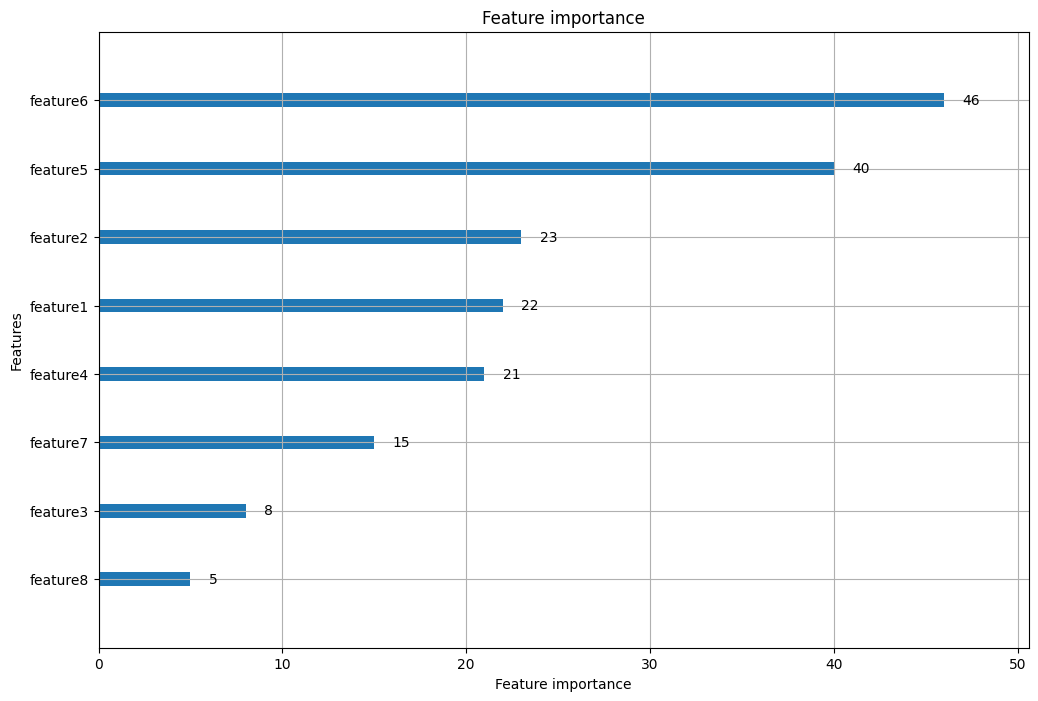

In [65]:
lgb.plot_importance(ranker1, figsize = (12,8))

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

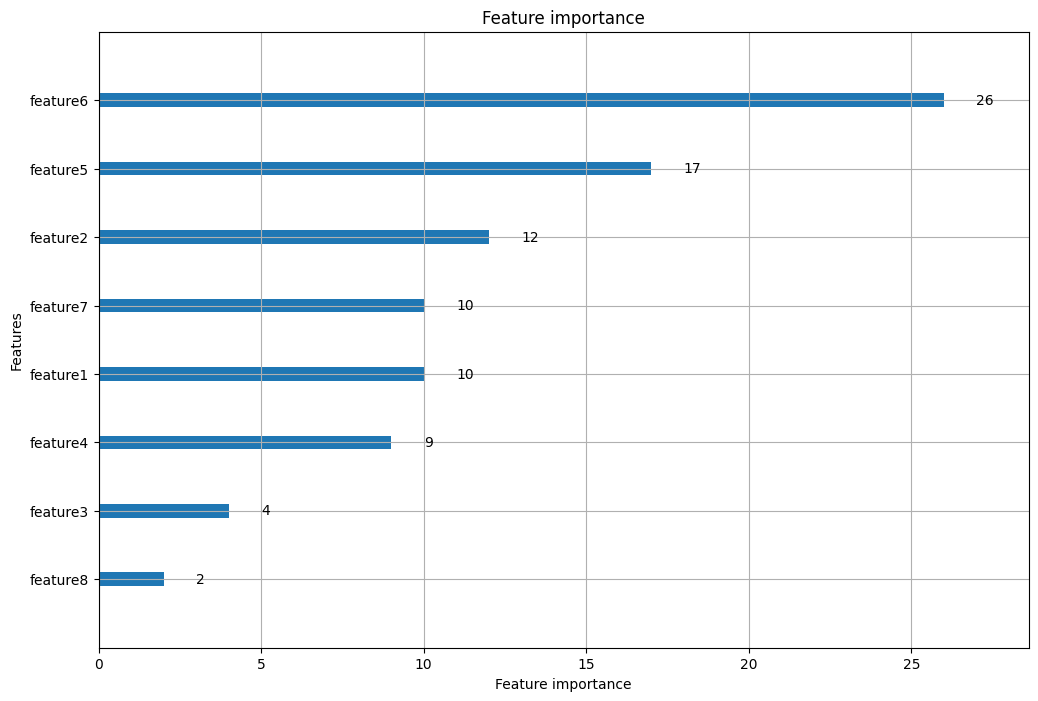

In [66]:
lgb.plot_importance(ranker2, figsize = (12,8))